In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re


In [ ]:
# import os
# import shutil
# import re

# def filter(input_folder, output_base_folder):
#     # Make sure input folder exists
#     if not os.path.isdir(input_folder):
#         print(f"Error: {input_folder} is not a valid directory.")
#         return

#     # Create the output base folder if it doesn't exist
#     os.makedirs(output_base_folder, exist_ok=True)

#     # Iterate over each item in the input folder
#     for item in os.listdir(input_folder):
#         item_path = os.path.join(input_folder, item)

#         # Skip unwanted files/folders
#         if "patched_" in item_path or item_path[-3:] == 'tif' or os.path.isdir(item_path):
#             continue

#         # Get file size
#         size = os.stat(item_path).st_size

#         # Apply all filters
#         if (
#             size > 2000 and
#             re.search(r"patch\d{1,3}", item, re.IGNORECASE) and
#             re.search(r"sox", item, re.IGNORECASE)
#         ):
#             shutil.copy(item_path, output_base_folder)
#             # print(f"Copied '{item}' to '{output_base_folder}'")

# # Call the function
# if __name__ == "__main__":
#     input_folder = '/content/drive/My Drive/CMIL_SP2025_Patches_Apr16'  # Or your shared folder shortcut
#     output_base_folder = '/content/drive/My Drive/filtered_patches_SP2025_sox'

#     filter(input_folder, output_base_folder)


In [ ]:
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1  # Benign = 0, High-grade = 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# Load case-grade label mapping
labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv')

# Paths to filtered stain patches
patch_dirs = {
    'he': '/content/drive/My Drive/filtered_patches_SP2025_h&e',
    'melan': '/content/drive/My Drive/filtered_patches_SP2025_melan',
    'sox': '/content/drive/My Drive/filtered_patches_SP2025_sox',
}

# Group patches for each stain
patches_all = {stain: group_patches(path) for stain, path in patch_dirs.items()}


In [ ]:
# Intersect cases shared across all three stain types
shared_cases = set.intersection(*(set(patches.keys()) for patches in patches_all.values()))

# Keep only cases with class labels 1, 3, or 4 and among shared cases
filtered_labels = labels[(labels['Case'].isin(shared_cases)) & (labels['Class'].isin([1, 3, 4]))].copy()

# OPTIONAL: Recode classes to contiguous labels for model training
# e.g. Map {1 → 1, 3 → 1, 4 → 1} if you want to use 0-based labels
label_map = {1: 0, 3: 1, 4: 1}
filtered_labels['Class'] = filtered_labels['Class'].map(label_map)
filtered_labels['Class'] = filtered_labels['Class'].astype(int)

# Prepare inputs
X = filtered_labels['Case'].reset_index(drop=True)
y = filtered_labels['Class'].reset_index(drop=True)

# Stratified splitting across three classes (0, 1, 2 after remapping)
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
def get_case_patch_subset(case_list, patches_dict):
    return {case: patches_dict[case] for case in case_list if case in patches_dict}

datasets = {}
for stain in ['he', 'melan', 'sox']:
    datasets[stain] = {
        'train': get_case_patch_subset(train_X, patches_all[stain]),
        'val': get_case_patch_subset(val_X, patches_all[stain]),
        'test': get_case_patch_subset(test_X, patches_all[stain]),
    }


In [ ]:
# Base transform for val/test
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
datasets_loaders = {}

for stain in ['he', 'melan', 'sox']:
    datasets_loaders[stain] = {
        'train': DataLoader(PNGDataset(datasets[stain]['train'], labels, transform=train_transform),
                            batch_size=32, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(PNGDataset(datasets[stain]['val'], labels, transform=transform),
                          batch_size=32, shuffle=False),
        'test': DataLoader(PNGDataset(datasets[stain]['test'], labels, transform=transform),
                           batch_size=32, shuffle=False),
    }


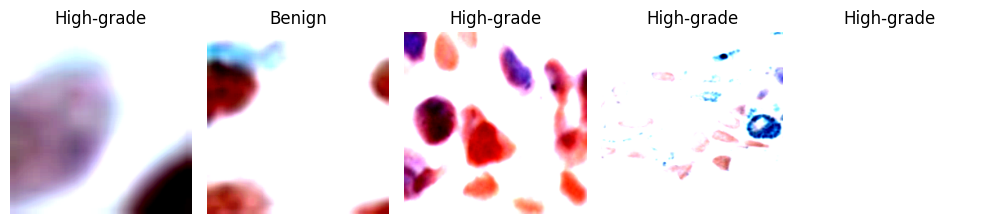

In [ ]:
images, labels_batch = next(iter(datasets_loaders['sox']['train']))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels_batch[i] == 0 else 'High-grade')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def get_patch_predictions_from_checkpoint(
    stain_name: str,
    test_loader: DataLoader,
    test_dataset: Dataset,
    test_patches: dict,
    checkpoint_path: str,
    num_classes: int = 2  # or whatever number you're using
):
    print(f"🔍 Getting predictions from {stain_name.upper()}...")

    # Load model
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    all_preds = []
    with torch.no_grad():
        for images, _ in test_loader:
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())

    image_to_case = {}
    for case_num, patches in test_patches.items():
        for patch in patches:
            image_to_case[patch] = case_num

    patch_to_case = {}
    patch_predictions = {}
    patch_labels = {}

    for i in range(len(test_dataset)):
        image_path = test_dataset.image_paths[i]
        label = test_dataset.labels[i]
        patch_to_case[image_path] = image_to_case[image_path]
        patch_predictions[image_path] = all_preds[i]
        patch_labels[image_path] = label

    # RETURN ALL THREE
    return patch_predictions, patch_labels, patch_to_case

def get_patch_probabilities_from_checkpoint(
    stain_name: str,
    test_loader: DataLoader,
    test_dataset: Dataset,
    test_patches: dict,
    checkpoint_path: str,
    num_classes: int = 2
):
    print(f"🔍 Getting probabilities from {stain_name.upper()}...")

    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    image_to_case = {}
    for case_num, patches in test_patches.items():
        for patch in patches:
            image_to_case[patch] = case_num

    patch_to_case = {}
    patch_probabilities = {}
    patch_labels = {}

    for i in range(len(test_dataset)):
        image_path = test_dataset.image_paths[i]
        label = test_dataset.labels[i]
        patch_to_case[image_path] = image_to_case[image_path]
        patch_probabilities[image_path] = all_probs[i]
        patch_labels[image_path] = label

    return patch_probabilities, patch_labels, patch_to_case



In [ ]:
# # Define checkpoints
ckpt_paths = {
    'he':    "/content/drive/My Drive/checkpoints/20250422_080006_resnet50_hande_epoch4.pth",
    'melan': "/content/drive/My Drive/checkpoints/20250422_150354_resnet50_melan_epoch3.pth",
    'sox':   "/content/drive/My Drive/checkpoints/20250423_004114_resnet50_sox_epoch4.pth",
}

# Collect predictions
all_patch_preds = {}
all_patch_labels = {}
all_patch_to_case = {}

for stain in ['he', 'melan', 'sox']:
    preds, labels, patch_to_case = get_patch_predictions_from_checkpoint(
        stain_name=stain,
        test_loader=datasets_loaders[stain]['test'],
        test_dataset=datasets_loaders[stain]['test'].dataset,
        test_patches=datasets[stain]['test'],
        checkpoint_path=ckpt_paths[stain]
    )

    all_patch_preds[stain] = preds
    all_patch_labels.update(labels)         # ✅ merge all label mappings
    all_patch_to_case.update(patch_to_case) # ✅ merge all patch-case mappings

# ✅ Use the merged dictionaries
patch_labels = all_patch_labels
patch_to_case = all_patch_to_case

print(f"✅ Total patches from all models: {sum(len(p) for p in all_patch_preds.values())}")
print(f"✅ Total patch-to-case mappings: {len(patch_to_case)}")
print(f"✅ Total patch labels: {len(patch_labels)}")



🔍 Getting predictions from HE...
🔍 Getting predictions from MELAN...
🔍 Getting predictions from SOX...
✅ Total patches from all models: 5262
✅ Total patch-to-case mappings: 5262
✅ Total patch labels: 5262


In [ ]:
# import torch.nn.functional as F

# all_patch_probs = {}
# all_patch_labels = {}
# all_patch_to_case = {}

# for stain in ['he', 'melan', 'sox']:
#     probs, labels, patch_to_case = get_patch_probabilities_from_checkpoint(
#         stain_name=stain,
#         test_loader=datasets_loaders[stain]['test'],
#         test_dataset=datasets_loaders[stain]['test'].dataset,
#         test_patches=datasets[stain]['test'],
#         checkpoint_path=ckpt_paths[stain],
#         num_classes=2
#     )
#     all_patch_probs[stain] = probs
#     all_patch_labels.update(labels)
#     all_patch_to_case.update(patch_to_case)

In [ ]:
# X_meta = []
# y_meta = []
# patch_paths_used = []
# missing = []

# for patch_path in all_patch_probs['sox'].keys():
#     try:
#         features = np.concatenate([
#             all_patch_probs['he'][patch_path],
#             all_patch_probs['melan'][patch_path],
#             all_patch_probs['sox'][patch_path],
#         ])
#         label = all_patch_labels[patch_path]
#         X_meta.append(features)
#         y_meta.append(label)
#         patch_paths_used.append(patch_path)
#     except KeyError:
#         missing.append(patch_path)

# X_meta = np.array(X_meta)
# y_meta = np.array(y_meta)

In [ ]:
# from sklearn.linear_model import LogisticRegression

# meta_model = LogisticRegression(max_iter=1000)
# meta_model.fit(X_meta, y_meta)

# y_pred_meta = meta_model.predict(X_meta)

# # Map predictions back to patch paths
# patch_ensemble_preds = {
#     patch_path: pred for patch_path, pred in zip(patch_paths_used, y_pred_meta)
# }

In [ ]:
from collections import defaultdict, Counter

# For each patch path, collect votes
patch_votes = defaultdict(list)

for stain_preds in all_patch_preds.values():
    for patch_path, pred in stain_preds.items():
        patch_votes[patch_path].append(pred)

# Final ensemble prediction (majority vote)
patch_ensemble_preds = {patch: Counter(votes).most_common(1)[0][0]
                        for patch, votes in patch_votes.items()}


In [ ]:
# from collections import defaultdict

# case_predictions = defaultdict(list)
# case_true_labels = {}
# missing_patches = []

# for patch_path, pred in patch_ensemble_preds.items():
#     try:
#         case_num = all_patch_to_case[patch_path]
#         true_label = all_patch_labels[patch_path]
#     except KeyError:
#         print(f"⚠️ Skipping missing patch: {patch_path}")
#         missing_patches.append(patch_path)
#         continue

#     case_predictions[case_num].append(pred)
#     case_true_labels[case_num] = true_label

# case_accuracies = {}
# for case_num, preds in case_predictions.items():
#     true_label = case_true_labels[case_num]
#     correct = sum(p == true_label for p in preds)
#     accuracy = correct / len(preds) if preds else 0
#     case_accuracies[case_num] = accuracy

# print("\n📊 Patch-Level Stacking Ensemble Accuracy per Case:")
# for case_num, acc in sorted(case_accuracies.items()):
#     label_str = "Benign" if case_true_labels[case_num] == 0 else "High-grade CMIL"
#     print(f"Case {case_num}: Patch Accuracy = {acc:.4f}, True Label = {label_str}")

# print(f"\n✅ Evaluated {len(case_accuracies)} cases.")
# print(f"⚠️ Skipped {len(missing_patches)} patches due to missing mapping.")


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # --- Classification Report ---
# print("\n📊 Patch-Level Classification Report (Stacking Meta-Model):")
# print(classification_report(y_meta, y_pred_meta, target_names=["Benign", "High-grade CMIL"]))

# # --- Confusion Matrix ---
# cm = confusion_matrix(y_meta, y_pred_meta)

# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=['Benign', 'High-grade CMIL'],
#             yticklabels=['Benign', 'High-grade CMIL'])

# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix – Stacking Ensemble (Patch Level)")
# plt.tight_layout()
# plt.show()


In [ ]:
case_predictions = defaultdict(list)
case_true_labels = {}
missing_patches = []

for patch_path, pred in patch_ensemble_preds.items():
    try:
        case_num = patch_to_case[patch_path]
        true_label = patch_labels[patch_path]
    except KeyError:
        print(f"⚠️ Skipping missing patch: {patch_path}")
        missing_patches.append(patch_path)
        continue

    case_predictions[case_num].append(pred)
    case_true_labels[case_num] = true_label

case_accuracies = {}
for case_num, preds in case_predictions.items():
    true_label = case_true_labels[case_num]
    correct = sum(p == true_label for p in preds)
    accuracy = correct / len(preds) if preds else 0
    case_accuracies[case_num] = accuracy

# Print
print("\n📊 Patch-Level Majority Vote Accuracy per Case:")
for case_num, acc in sorted(case_accuracies.items()):
    label_str = "Benign" if case_true_labels[case_num] == 0 else "High-grade CMIL"
    print(f"Case {case_num}: Patch Accuracy = {acc:.4f}, True Label = {label_str}")

# Optional summary
print(f"\n✅ Evaluated {len(case_accuracies)} cases.")
print(f"⚠️ Skipped {len(missing_patches)} patches due to missing mapping.")


📊 Patch-Level Majority Vote Accuracy per Case:
Case 3: Patch Accuracy = 0.8746, True Label = High-grade CMIL
Case 5: Patch Accuracy = 0.9909, True Label = High-grade CMIL
Case 15: Patch Accuracy = 0.7923, True Label = High-grade CMIL
Case 30: Patch Accuracy = 0.7832, True Label = Benign
Case 78: Patch Accuracy = 0.7068, True Label = Benign
Case 88: Patch Accuracy = 0.9504, True Label = High-grade CMIL
Case 92: Patch Accuracy = 0.8241, True Label = High-grade CMIL
Case 93: Patch Accuracy = 0.5405, True Label = Benign
Case 97: Patch Accuracy = 0.5339, True Label = High-grade CMIL

✅ Evaluated 9 cases.
⚠️ Skipped 0 patches due to missing mapping.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_true = []
y_pred = []
missing_patches = []

for patch_path in patch_ensemble_preds:
    try:
        true_label = patch_labels[patch_path]
        pred_label = patch_ensemble_preds[patch_path]
    except KeyError:
        print(f"⚠️ Missing data for patch: {patch_path}")
        missing_patches.append(patch_path)
        continue

    y_true.append(true_label)
    y_pred.append(pred_label)

print(f"\n✅ Included {len(y_true)} patches in evaluation.")
print(f"⚠️ Skipped {len(missing_patches)} patches due to missing ground truth.")

print(classification_report(y_true, y_pred, target_names=["Benign", "High-grade CMIL"]))



✅ Included 5262 patches in evaluation.
⚠️ Skipped 0 patches due to missing ground truth.
                 precision    recall  f1-score   support

         Benign       0.42      0.64      0.51      1202
High-grade CMIL       0.87      0.73      0.80      4060

       accuracy                           0.71      5262
      macro avg       0.65      0.69      0.65      5262
   weighted avg       0.77      0.71      0.73      5262



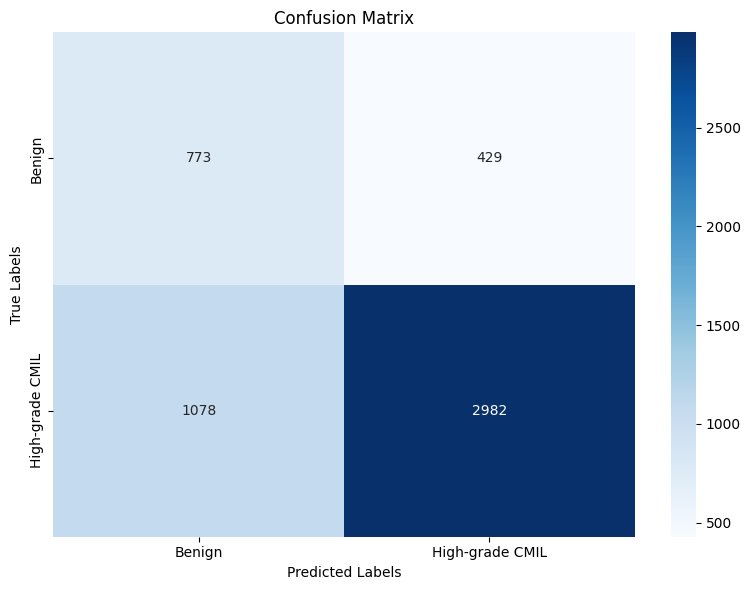

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()